In [1]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

def process_pcap(pcap_file, port=5000, window_size=100):
    if not os.path.isfile(pcap_file):
        raise FileNotFoundError(f"Pcap file '{pcap_file}' not found.")

    csv_file = os.path.splitext(os.path.basename(pcap_file))[0] + '_data.csv'

    tshark_command = [
        'tshark',
        '-r', pcap_file,
        '-Y', f'tcp.port == {port}',
        '-T', 'fields',
        '-e', 'frame.time_epoch',
        '-e', 'tcp.seq',
        '-e', 'tcp.len',
        '-e', 'tcp.analysis.retransmission',
        '-e', 'tcp.analysis.ack_rtt',
        '-E', 'header=y',
        '-E', 'separator=,',
        '-E', 'quote=d',
        '-E', 'occurrence=f'
    ]

    with open(csv_file, 'w') as f:
        subprocess.run(tshark_command, stdout=f, stderr=subprocess.PIPE)

    df = pd.read_csv(
        csv_file,
        names=['timestamp', 'seq', 'len', 'retransmission', 'ack_rtt'],
        header=0,
        dtype={
            'timestamp': float,
            'seq': int,
            'len': int,
            'retransmission': str,  
            'ack_rtt': float
        }
    )

    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['iat_sec'] = df['timestamp'].diff()
    df['iat_ms'] = df['iat_sec'] * 1000
    df['jitter_ms'] = df['iat_ms'].diff().abs()
    df['is_retransmission'] = df['retransmission'].notna()
    df['expected_seq'] = df['seq'].shift(1) + df['len'].shift(1)
    df['seq_gap'] = df['seq'] - df['expected_seq']
    df['packet_loss'] = df['seq_gap'] > 0
    df['rtt_ms'] = df['ack_rtt'] * 1000
    start_time = df['timestamp'].iloc[0] if len(df) > 0 else 0
    df['relative_time'] = df['timestamp'] - start_time
    df['packet_index'] = df.index + 1
    df['cumulative_loss'] = df['packet_loss'].cumsum()
    df['jitter_roll_ms'] = df['jitter_ms'].rolling(window=window_size, min_periods=1).mean()
    if df['rtt_ms'].notna().any():
        df['rtt_roll_ms'] = df['rtt_ms'].rolling(window=window_size, min_periods=1).mean()
    else:
        df['rtt_roll_ms'] = np.nan
    return df


In [3]:
def plot_jitter(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['jitter_ms'].notna().any():
            plt.plot(df['relative_time'], df['jitter_ms'], linewidth=0.5, label=label)
    plt.xlabel('Time (s from start)')
    plt.ylabel('Jitter (ms)')
    plt.title('TCP Jitter Over Relative Time')
    plt.grid(True)
    # plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rtt(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['rtt_ms'].notna().any():
            plt.plot(df['relative_time'], df['rtt_ms'], linewidth=1, label=label)
    plt.xlabel('Time (s from start)')
    plt.ylabel('RTT (ms)')
    plt.title('RTT vs Relative Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.yscale('log')
    plt.show()

def plot_jitter_rolling(dfs, labels, window_size=100):

    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['jitter_ms'].notna().any():
            df_clean = df.dropna(subset=['relative_time', 'jitter_ms'])
            df_sorted = df_clean.sort_values('relative_time')
            df_sorted['jitter_roll_avg'] = df_sorted['jitter_ms'].rolling(window=window_size, min_periods=1).mean()
            plt.plot(df_sorted['relative_time'], df_sorted['jitter_roll_avg'], label=f'{label}',linestyle='-',marker='',linewidth=2)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Jitter (ms)', fontsize=12)
    plt.title(f'Jitter vs Time', fontsize=14)
    # plt.ylim([0, 20])
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('jitter_time_50_10.pdf')
    plt.show()

def plot_rtt_rolling(dfs, labels, window_size=100):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        if df['rtt_roll_ms'].notna().any():
            df_clean = df.dropna(subset=['relative_time', 'rtt_roll_ms'])
            df_sorted = df_clean.sort_values('relative_time')
            plt.plot(df_sorted['relative_time'], df_sorted['rtt_roll_ms'], label=label,linestyle='-',marker='',linewidth=2)    
    plt.axhline(y=30, color='red', linestyle='--', linewidth=2, label='Base RTT')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('RTT (ms)', fontsize=12)
    plt.title(f'RTT vs Relative Time', fontsize=14)
    # plt.ylim([28, 3000])
    # plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('rtt_time_50_10.pdf')
    plt.show()


def plot_jitter_cdf(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        jitter_values = df['jitter_ms'].dropna()
        if len(jitter_values) > 0:
            ecdf_jitter = ECDF(jitter_values)
            plt.plot(ecdf_jitter.x, ecdf_jitter.y, label=label)
    plt.xlabel('Jitter (ms)')
    plt.ylabel('CDF')
    plt.title('CDF of Jitter')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig('jitter_time_cdf_50_10.pdf')
    plt.show()

def plot_rtt_cdf(dfs, labels):
    plt.figure(figsize=(12, 6))
    for df, label in zip(dfs, labels):
        rtt_values = df['rtt_ms'].dropna()
        if len(rtt_values) > 0:
            ecdf_rtt = ECDF(rtt_values)
            plt.plot(ecdf_rtt.x, ecdf_rtt.y, label=label)
    plt.xlabel('RTT (ms)')
    plt.ylabel('CDF')
    plt.title('CDF of RTT')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig('rtt_time_cdf_50_10.pdf')
    plt.show()


In [4]:
pcaps = [
    './captures/solo_flow/cubic_50_10.pcap',
    './captures/solo_flow/reno_50_10.pcap',
    './captures/solo_flow/l4s_50_10.pcap',
    './captures/solo_flow/prague_50_10.pcap'
]
dfs = []
labels = []
for pcap_file in pcaps:
    df = process_pcap(pcap_file, port=5000, window_size=100)
    df2 = process_pcap(pcap_file, port=5000, window_size=100)
    dfs.append(df)
    label_name = 'TCP ' +os.path.splitext(os.path.basename(pcap_file))[0].split('_')[0]
    labels.append(label_name)

In [5]:
for df, label in zip(dfs, labels):
    print(label, df['rtt_roll_ms'].mean())

TCP cubic 218.58623833953337
TCP reno 184.5516995001594
TCP l4s 101.19929848629106
TCP prague 196.26121316080315


In [6]:
for df, label in zip(dfs, labels):
    print(label, df['jitter_roll_ms'].mean())

TCP cubic 1.6339248842235061
TCP reno 1.5751289577713385
TCP l4s 0.9166882455587902
TCP prague 1.0938370270682372


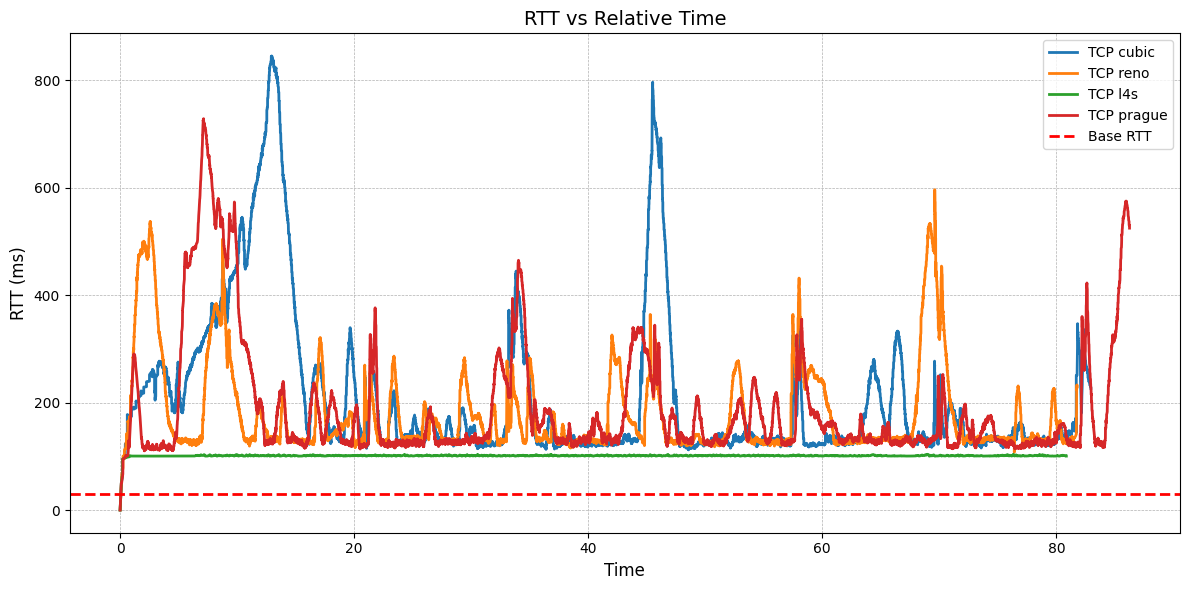

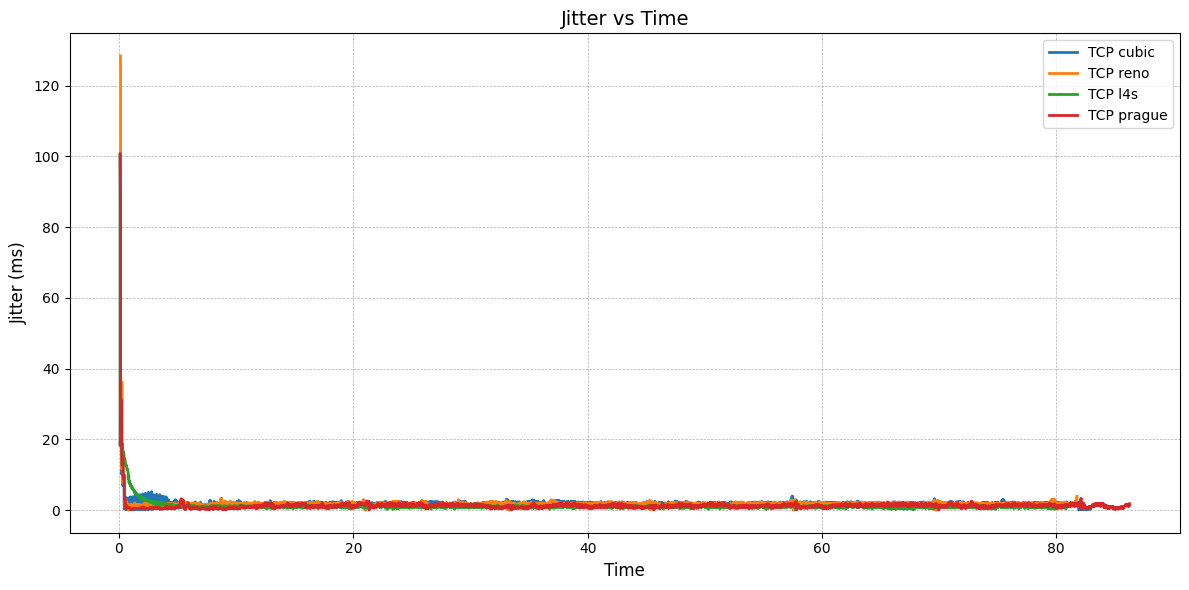

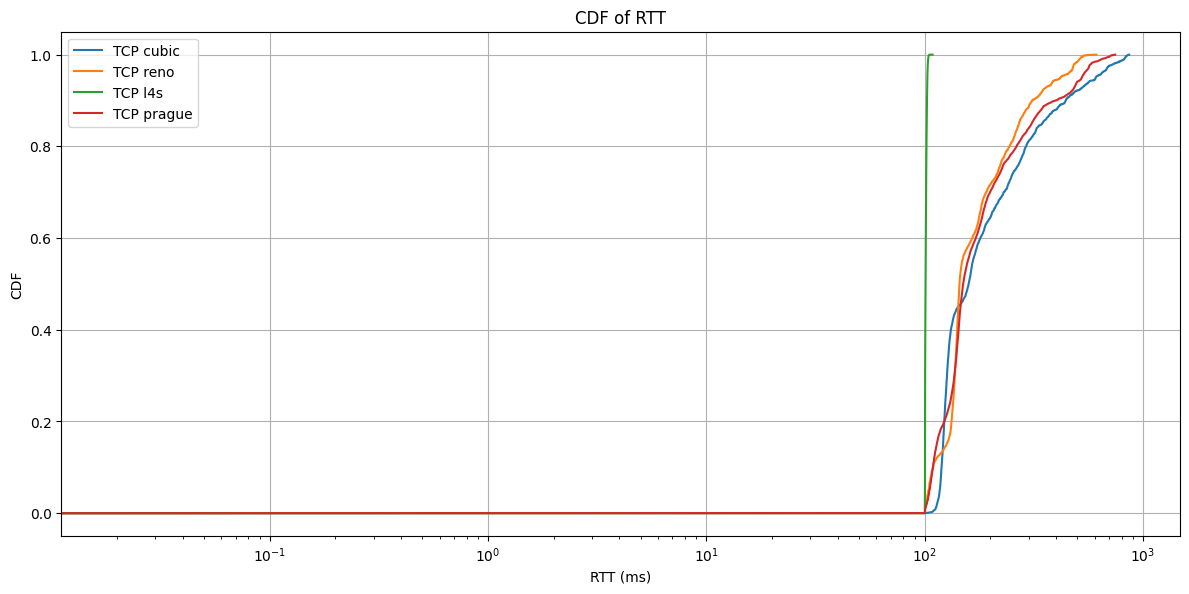

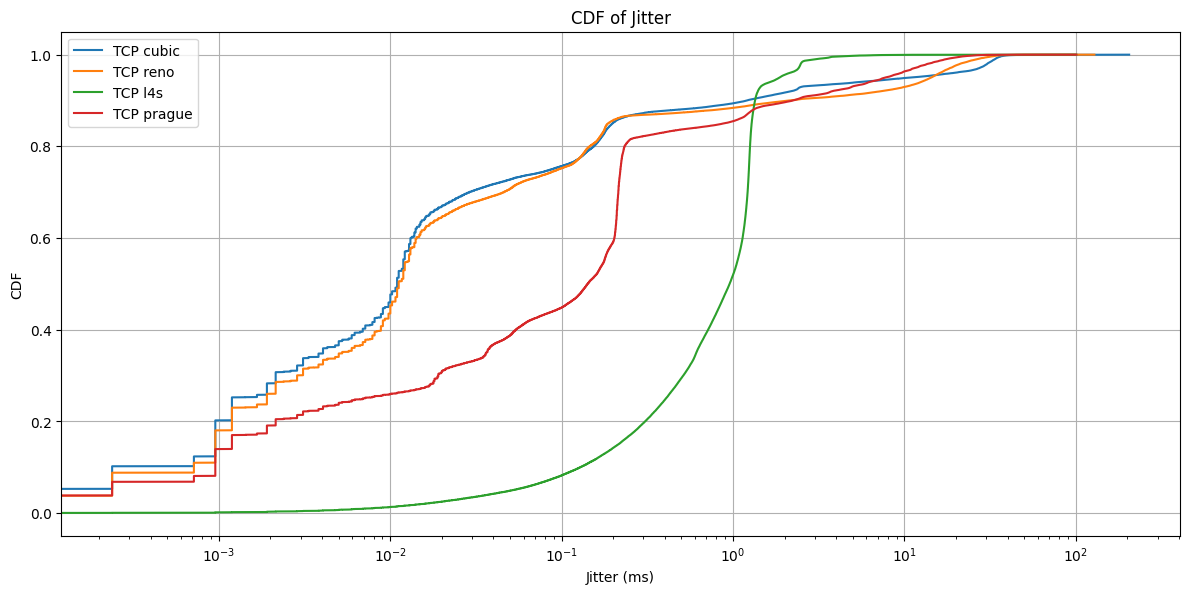

In [7]:
plot_rtt_rolling(dfs, labels, window_size=100)
plot_jitter_rolling(dfs, labels)
plot_rtt_cdf(dfs, labels)
plot_jitter_cdf(dfs, labels)

Percentage of Packet Drops:
----------------------------
TCP Cubic: 0.00%
TCP Reno: 0.00%
TCP L4s: 0.00%
TCP Prague: 0.00%


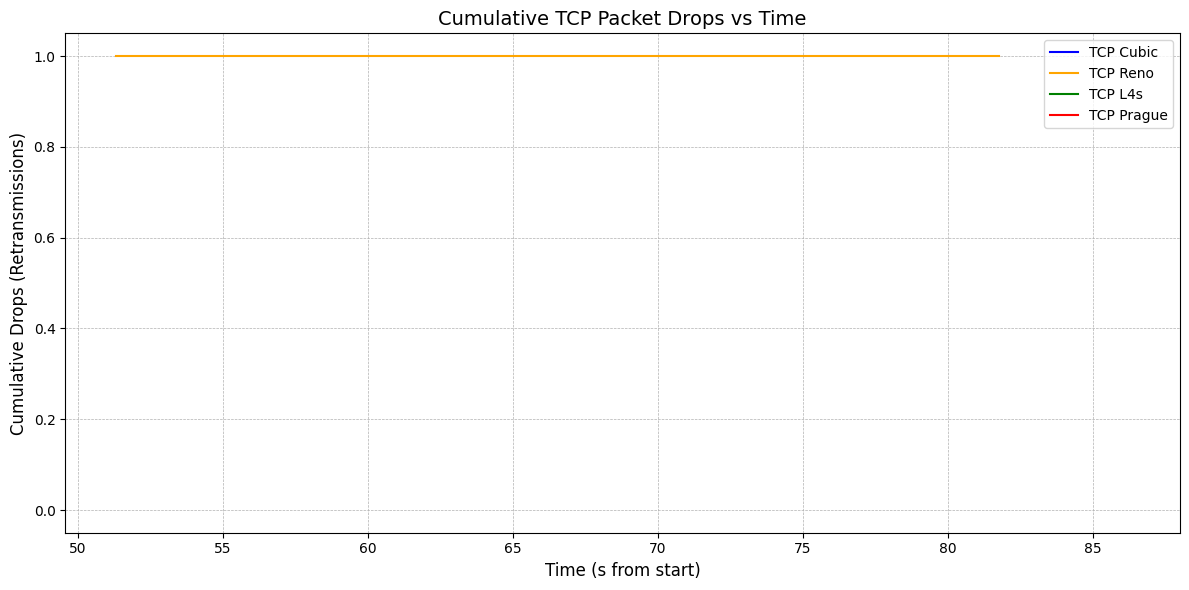

In [ ]:
from scapy.all import rdpcap, TCP
import matplotlib.pyplot as plt
import os

def get_pkt_drops(pcap_file):
    try:
        packets = rdpcap(pcap_file)
    except FileNotFoundError:
        print(f"File not found: {pcap_file}")
        return None
    except Exception as e:
        print(f"Error reading {pcap_file}: {e}")
        return None

    filtered_packets = [p for p in packets if p.haslayer(TCP) and p[TCP].sport == 5000]
    if not filtered_packets:
        print(f"No packets found with TCP source port 5000 in {pcap_file}.")
        return None

    filtered_packets.sort(key=lambda x: x.time)
    start_time = filtered_packets[0].time
    end_time = filtered_packets[-1].time
    rel_end_time = end_time - start_time

    seen_sequences = {}
    cumulative_count = 0
    retransmissions = []

    for p in filtered_packets:
        seq = p[TCP].seq
        pkt_time = p.time
        if seq not in seen_sequences:
            seen_sequences[seq] = pkt_time
        else:
            cumulative_count += 1
            rel_time = pkt_time - start_time
            retransmissions.append((rel_time, cumulative_count))

    base_name = os.path.splitext(os.path.basename(pcap_file))[0]
    protocol = base_name.split('_')[0].capitalize()
    label_name = f'TCP {protocol}'

    if not retransmissions:
        retransmissions.append((rel_end_time, cumulative_count))

    last_time, last_count = retransmissions[-1]

    return {
        'label': label_name,
        'times': [t for t, c in retransmissions],
        'counts': [c for t, c in retransmissions],
        'end_time': rel_end_time,
        'retransmissions': cumulative_count,
        'total_packets': len(filtered_packets)
    }

pcap_files = [
    './captures/solo_flow/cubic_50_10.pcap',
    './captures/solo_flow/reno_50_10.pcap',
    './captures/solo_flow/l4s_50_10.pcap',
    './captures/solo_flow/prague_50_10.pcap'
]

data_list = []
for pcap in pcap_files:
    data = get_pkt_drops(pcap)
    if data:
        data_list.append(data)

if not data_list:
    print("No valid data to plot.")
    exit(0)

color_map = {
    'TCP Reno': 'orange',
    'TCP Cubic': 'blue',
    'TCP L4s': 'green',
    'TCP Prague': 'red'  
}

plt.figure(figsize=(12, 6))

print("Percentage of Packet Drops:")
print("----------------------------")
for d in data_list:
    label = d['label']
    retrans = d['retransmissions']
    total = d['total_packets']
    percentage = (retrans / total) * 100 if total > 0 else 0
    print(f"{label}: {percentage:.2f}%")

    times = d['times']
    counts = d['counts']
    color = color_map.get(label, None)
    if len(times) == 1 and counts[0] == 0:
        times.append(d['end_time'])
        counts.append(0)
    elif times[-1] < d['end_time']:
        times.append(d['end_time'])
        counts.append(counts[-1])

    plt.step(times, counts, where='post', label=label, color=color)

plt.xlabel("Time (s from start)", fontsize=12)
plt.ylabel("Cumulative Drops (Retransmissions)", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.title("Cumulative TCP Packet Drops vs Time", fontsize=14)
plt.tight_layout()
plt.savefig('packet_drop_50_10.pdf')

plt.show()


Mean Throughput for Each Flow:
-------------------------------
Processing file: ./captures/solo_flow/cubic_50_10.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_28204/470758746.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


CUBIC: 8.61 Mbps
Processing file: ./captures/solo_flow/reno_50_10.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_28204/470758746.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


Reno: 8.68 Mbps
Processing file: ./captures/solo_flow/l4s_50_10.pcap


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_28204/470758746.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


L4S: 8.74 Mbps
Processing file: ./captures/solo_flow/prague_50_10.pcap
Prague: 8.60 Mbps


/var/folders/pz/k6xzp7dd2d5bmltf7tyypph80000gn/T/ipykernel_28204/470758746.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput = df.groupby('bin')['bytes'].sum().values


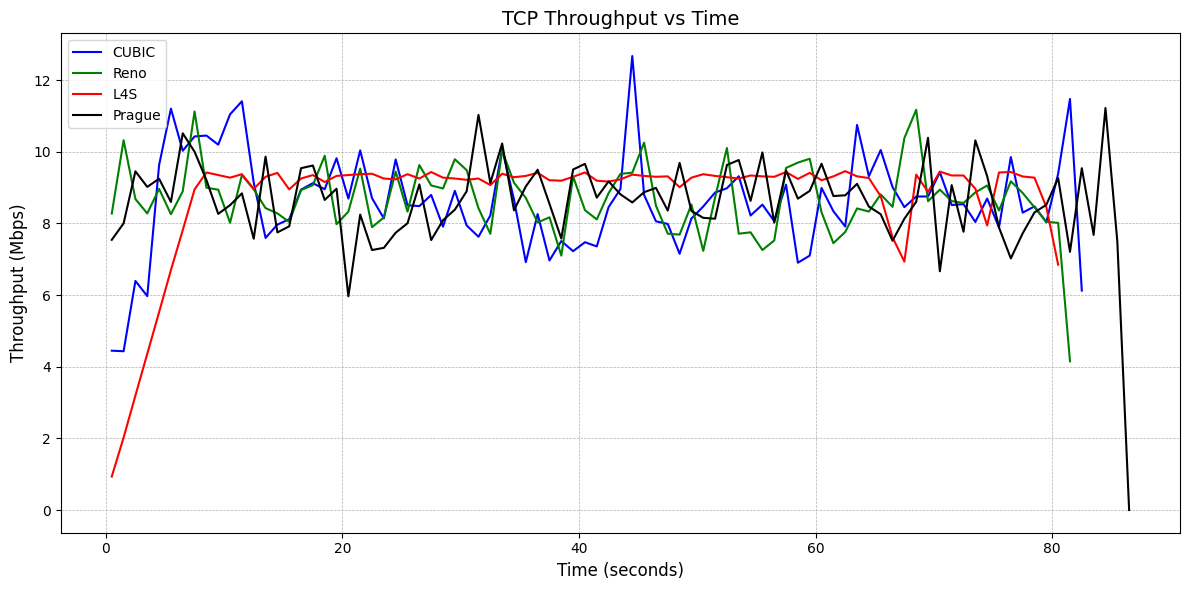


Overall Mean Throughput Across All Flows:
8.66 Mbps


In [ ]:
import os
import sys
from scapy.all import rdpcap, TCP
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def process_pcap(file_path, src_port=5000, bin_size=1):
    print(f"Processing file: {file_path}")
    
    try:
        packets = rdpcap(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None, None, None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None, None
    
    if not packets:
        print(f"No packets found in {file_path}.")
        return None, None, None
    packet_times = []
    packet_lengths = []
    for pkt in packets:
        if TCP in pkt and pkt[TCP].sport == src_port:
            packet_times.append(pkt.time)
            packet_lengths.append(len(pkt))
    
    if not packet_times:
        print(f"No TCP packets with source port {src_port} found in {file_path}.")
        return None, None, None

    df = pd.DataFrame({
        'time': packet_times,
        'bytes': packet_lengths
    })

    start_time = df['time'].min()
    df['time'] = df['time'] - start_time

    max_time = df['time'].max()
    bins = np.arange(0, max_time + bin_size, bin_size)
    df['bin'] = pd.cut(df['time'], bins, right=False)
    throughput = df.groupby('bin')['bytes'].sum().values

    throughput_mbps = (throughput * 8) / (1e6 * bin_size)

    time_bins = bins[:-1] + bin_size / 2  

    mean_throughput = np.mean(throughput_mbps) if len(throughput_mbps) > 0 else 0

    return time_bins, throughput_mbps, mean_throughput

def main():
    pcaps = [
        './captures/solo_flow/cubic_50_10.pcap',
        './captures/solo_flow/reno_50_10.pcap',
        './captures/solo_flow/l4s_50_10.pcap',
        './captures/solo_flow/prague_50_10.pcap'
    ]

    labels = ['CUBIC', 'Reno', 'L4S', 'Prague']
    colors = ['blue', 'green', 'red', 'black']

    plt.figure(figsize=(12, 6))

    mean_throughputs = []

    all_time_bins = []
    all_throughputs = []

    print("Mean Throughput for Each Flow:")
    print("-------------------------------")
    for pcap, label, color in zip(pcaps, labels, colors):
        time_bins, throughput, mean_tput = process_pcap(pcap, src_port=5000, bin_size=1)
        if time_bins is None or throughput is None:
            print(f"Skipping {pcap} due to no data.")
            continue
        all_time_bins.append(time_bins)
        all_throughputs.append(throughput)
        mean_throughputs.append((label, mean_tput))
        plt.plot(time_bins, throughput, label=label, color=color)
        print(f"{label}: {mean_tput:.2f} Mbps")

    if not all_time_bins:
        print("No data to plot.")
        sys.exit(1)

    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Throughput (Mbps)', fontsize=12)
    plt.title('TCP Throughput vs Time', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('tput_50_10.pdf')
    plt.show()

    overall_mean = np.mean([mt[1] for mt in mean_throughputs]) if mean_throughputs else 0
    print("\nOverall Mean Throughput Across All Flows:")
    print(f"{overall_mean:.2f} Mbps")


main()
